In [133]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score, 
    normalized_mutual_info_score, 
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    auc, 
    ConfusionMatrixDisplay
)
import pyshark
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
print("All libraries are successfully imported!")


All libraries are successfully imported!


In [134]:
def pcap_to_dataframe(pcap_file):
    cap = pyshark.FileCapture(pcap_file)
    packet_data = []
    
    for packet in tqdm(cap, desc="Reading packets from PCAP"):
        packet_info = {}

        try:
            packet_info['timestamp'] = packet.sniff_time
            packet_info['length'] = packet.length

            if hasattr(packet, 'eth'):
                packet_info['eth_src'] = packet.eth.src
                packet_info['eth_dst'] = packet.eth.dst

            if hasattr(packet, 'ip'):
                packet_info['ip_src'] = packet.ip.src
                packet_info['ip_dst'] = packet.ip.dst
                packet_info['ip_version'] = packet.ip.version
                packet_info['ip_ihl'] = packet.ip.hdr_len
                packet_info['ip_tos'] = packet.ip.dsfield
                packet_info['ip_ttl'] = packet.ip.ttl
                packet_info['ip_protocol'] = packet.ip.proto
                packet_info['ip_flags'] = packet.ip.flags

            if hasattr(packet, 'tcp'):
                packet_info['tcp_srcport'] = packet.tcp.srcport
                packet_info['tcp_dstport'] = packet.tcp.dstport
                packet_info['tcp_seq'] = packet.tcp.seq
                packet_info['tcp_ack'] = packet.tcp.ack
                packet_info['tcp_flags'] = packet.tcp.flags

            if hasattr(packet, 'udp'):
                packet_info['udp_srcport'] = packet.udp.srcport
                packet_info['udp_dstport'] = packet.udp.dstport
                packet_info['udp_length'] = packet.udp.length

            if hasattr(packet, 'dns'):
                packet_info['dns_query'] = packet.dns.qry_name
                packet_info['dns_query_type'] = packet.dns.qry_type

            if hasattr(packet, 'http'):
                packet_info['http_method'] = packet.http.request_method
                packet_info['http_host'] = packet.http.host
                packet_info['http_uri'] = packet.http.request_uri
                packet_info['http_user_agent'] = packet.http.user_agent

            packet_info['raw_info'] = str(packet)

        except AttributeError:
            continue

        packet_data.append(packet_info)

    df = pd.DataFrame(packet_data)
    return df

def save_to_csv(df, output_csv):
    df.to_csv(output_csv, index=False)
    print(f"Data successfully written to {output_csv}")

if __name__ == "__main__":
    pcap_file = "data.pcap"
    output_csv = "output.csv"
    df = pcap_to_dataframe(pcap_file)
    save_to_csv(df, output_csv)

df.shape

Reading packets from PCAP: 0it [00:00, ?it/s]

Reading packets from PCAP: 12296it [00:19, 622.37it/s]


Data successfully written to output.csv


(12296, 21)

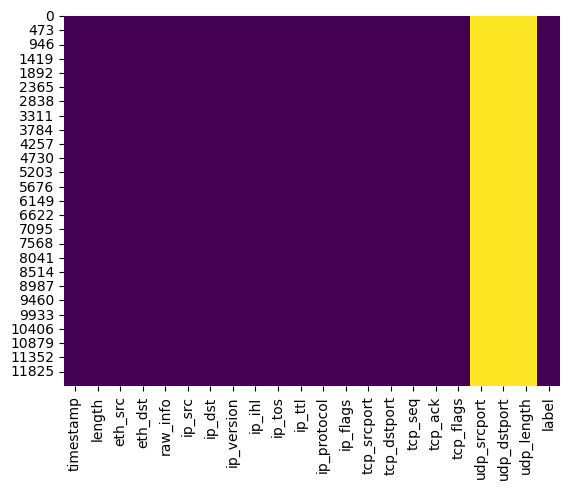

In [135]:
labels = pd.read_csv('data.csv', header=None, names=['label_data'])
labels[['index', 'label']] = labels['label_data'].str.split(';', expand=True)
labels.drop(columns=['label_data','index'], axis=1, inplace=True)
merged_df = pd.merge(df, labels, left_index=True, right_index=True)
merged_df['label'] = merged_df['label'].astype(int)
sns.heatmap(merged_df.isnull(), cbar=False,cmap='viridis')
plt.show()


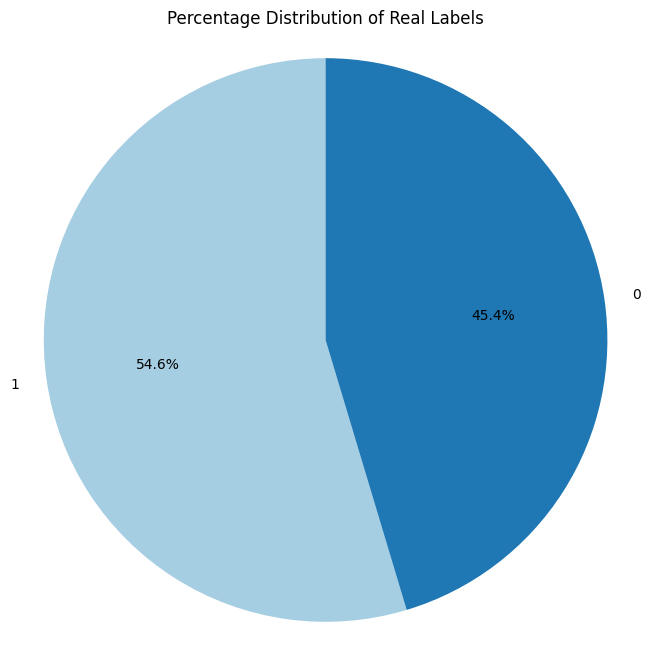

In [136]:
label_counts = merged_df['label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Percentage Distribution of Real Labels')
plt.axis('equal')
plt.show()

In [137]:
merged_df.drop(columns=['udp_srcport', 'udp_dstport', 'udp_length'], inplace=True)
merged_df.shape

(12296, 19)

In [138]:
merged_df= merged_df.dropna()
missing_values = merged_df.isnull().sum()
missing_values

timestamp      0
length         0
eth_src        0
eth_dst        0
raw_info       0
ip_src         0
ip_dst         0
ip_version     0
ip_ihl         0
ip_tos         0
ip_ttl         0
ip_protocol    0
ip_flags       0
tcp_srcport    0
tcp_dstport    0
tcp_seq        0
tcp_ack        0
tcp_flags      0
label          0
dtype: int64

In [139]:
merged_df

,timestamp,length,eth_src,eth_dst,raw_info,ip_src,ip_dst,ip_version,ip_ihl,ip_tos,ip_ttl,ip_protocol,ip_flags,tcp_srcport,tcp_dstport,tcp_seq,tcp_ack,tcp_flags,label
2,2015-02-24 18:27:45.728469,62,00:0c:29:f9:a8:75,00:0c:29:3c:11:3f,Packet (Length: 62)\nLayer ETH\n:\tDestination...,192.168.1.101,192.168.1.104,4,20,0x00,128,6,0x02,1631,502,0,0,0x0002,1
3,2015-02-24 18:27:45.728555,62,00:0c:29:3c:11:3f,00:0c:29:f9:a8:75,Packet (Length: 62)\nLayer ETH\n:\tDestination...,192.168.1.104,192.168.1.101,4,20,0x00,128,6,0x02,502,1631,0,1,0x0012,1
4,2015-02-24 18:27:45.728626,54,00:0c:29:f9:a8:75,00:0c:29:3c:11:3f,Packet (Length: 54)\nLayer ETH\n:\tDestination...,192.168.1.101,192.168.1.104,4,20,0x00,128,6,0x02,1631,502,1,1,0x0010,1
5,2015-02-24 18:27:45.876329,66,00:0c:29:f9:a8:75,00:0c:29:3c:11:3f,Packet (Length: 66)\nLayer ETH\n:\tDestination...,192.168.1.101,192.168.1.104,4,20,0x00,128,6,0x02,1631,502,1,1,0x0018,1
6,2015-02-24 18:27:45.877320,64,00:0c:29:3c:11:3f,00:0c:29:f9:a8:75,Packet (Length: 64)\nLayer ETH\n:\tDestination...,192.168.1.104,192.168.1.101,4,20,0x00,128,6,0x02,502,1631,1,13,0x0018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12291,2015-02-24 18:33:24.034179,66,00:0c:29:f9:a8:75,00:0c:29:3c:11:3f,Packet (Length: 66)\nLayer ETH\n:\tDestination...,192.168.1.101,192.168.1.104,4,20,0x00,128,6,0x02,1634,502,39745,29809,0x0018,1
12292,2015-02-24 18:33:24.035158,63,00:0c:29:3c:11:3f,00:0c:29:f9:a8:75,Packet (Length: 63)\nLayer ETH\n:\tDestination...,192.168.1.104,192.168.1.101,4,20,0x00,128,6,0x02,502,1634,29809,39757,0x0018,1
12293,2015-02-24 18:33:24.134951,66,00:0c:29:f9:a8:75,00:0c:29:3c:11:3f,Packet (Length: 66)\nLayer ETH\n:\tDestination...,192.168.1.101,192.168.1.104,4,20,0x00,128,6,0x02,1634,502,39757,29818,0x0018,1
12294,2015-02-24 18:33:24.135907,63,00:0c:29:3c:11:3f,00:0c:29:f9:a8:75,Packet (Length: 63)\nLayer ETH\n:\tDestination...,192.168.1.104,192.168.1.101,4,20,0x00,128,6,0x02,502,1634,29818,39769,0x0018,1


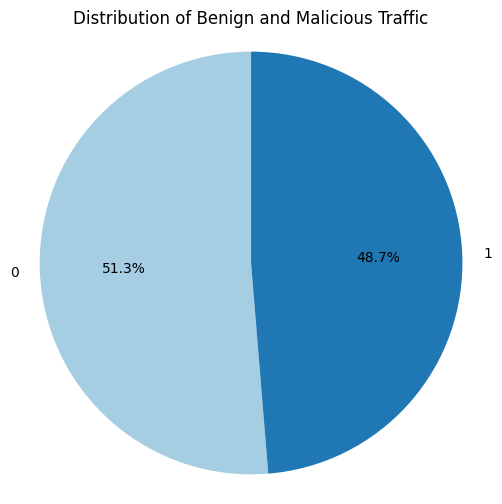

In [140]:
dfp=merged_df.copy()
new_df = merged_df[['tcp_seq', 'tcp_ack', 'length']].copy()
new_df['tcp_seq'] = pd.to_numeric(new_df['tcp_seq'], errors='coerce')
new_df['tcp_ack'] = pd.to_numeric(new_df['tcp_ack'], errors='coerce')
new_df['length'] = pd.to_numeric(new_df['length'], errors='coerce')

def label_traffic(row):
    if pd.notnull(row['tcp_seq']) and pd.notnull(row['tcp_ack']) and pd.notnull(row['length']):
        if (row['length'] > 100 or abs(row['tcp_seq'] - row['tcp_ack']) > 1000):
            return 1  
        else:
            return 0  
    else:
        return -1 

new_df['label'] = new_df.apply(label_traffic, axis=1)
label_counts = new_df['label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Benign and Malicious Traffic')
plt.axis('equal')  
plt.show()


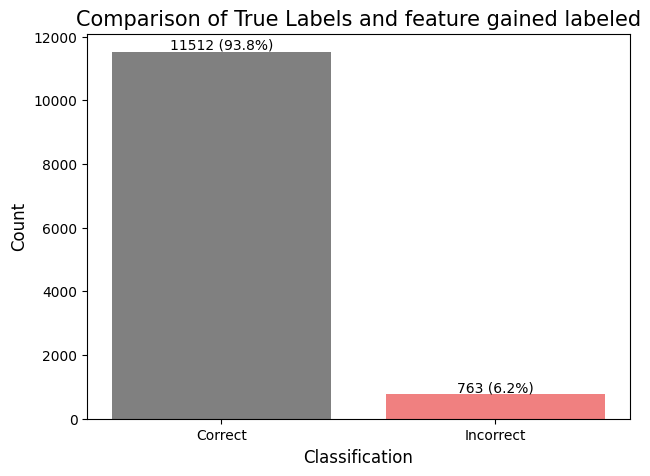

In [141]:
merged_df['simple_label'] = new_df['label'].astype(int)
merged_df['correct'] = merged_df['label'] == merged_df['simple_label']
comparison_counts_merged = merged_df['correct'].value_counts()
total_count_merged = len(merged_df)

fig, ax = plt.subplots(figsize=(7, 5))
bars_merged = ax.bar(comparison_counts_merged.index.map({True: 'Correct', False: 'Incorrect'}),
                     comparison_counts_merged.values,
                     color=['gray', 'lightcoral'])
ax.set_xlabel('Classification', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Comparison of True Labels and feature gained labeled', fontsize=15)
for bar in bars_merged:
    height = bar.get_height()
    percentage = (height / total_count_merged) * 100
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height} ({percentage:.1f}%)',
            ha='center', va='bottom')
plt.show()


In [142]:
dfp_su= merged_df.copy()
dfp.drop(columns='label',inplace=True)

In [143]:
# 'eth_src', 'eth_dst', 'ip_src', 'ip_dst' -> Data Leackage!

one_hot_cols = ['ip_tos', 'ip_flags', 'tcp_flags']
dfp_su = pd.get_dummies(dfp_su, columns=one_hot_cols, drop_first=True)
dfp_su['timestamp'] = pd.to_datetime(dfp_su['timestamp'])
dfp_su['timestamp_seconds'] = dfp_su['timestamp'].apply(lambda x: x.timestamp())
dfp_su.drop(columns=['timestamp'], inplace=True)
scaler = StandardScaler()
numeric_cols = ['length', 'ip_version', 'ip_ihl', 'ip_ttl', 'ip_protocol',
                'tcp_srcport', 'tcp_dstport', 'tcp_seq', 'tcp_ack', 'timestamp_seconds']
dfp_su[numeric_cols] = scaler.fit_transform(dfp_su[numeric_cols])
dfp_su_boolean_converted = dfp_su.select_dtypes(include=['bool']).astype(int)
dfp_su_numeric = dfp_su.select_dtypes(include=['float64', 'int64'])
dfp_su_combined = pd.concat([dfp_su_numeric, dfp_su_boolean_converted], axis=1)

Class distribution in training set:
label
1    5373
0    4447
Name: count, dtype: int64
Class distribution in test set:
label
1    1346
0    1109
Name: count, dtype: int64
Cross-validated accuracy: 0.80 (+/- 0.00)
Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.56      0.71      1109
           1       0.73      0.99      0.84      1346

    accuracy                           0.80      2455
   macro avg       0.86      0.78      0.78      2455
weighted avg       0.85      0.80      0.79      2455



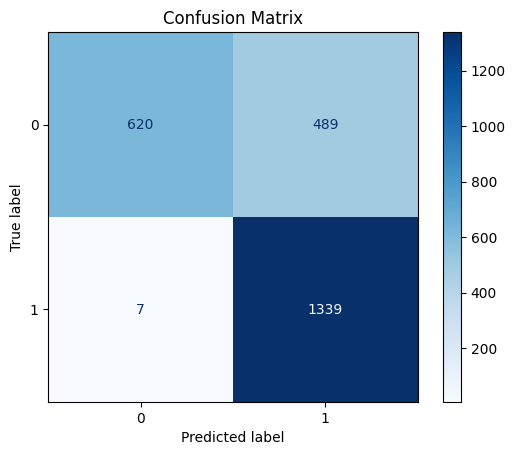

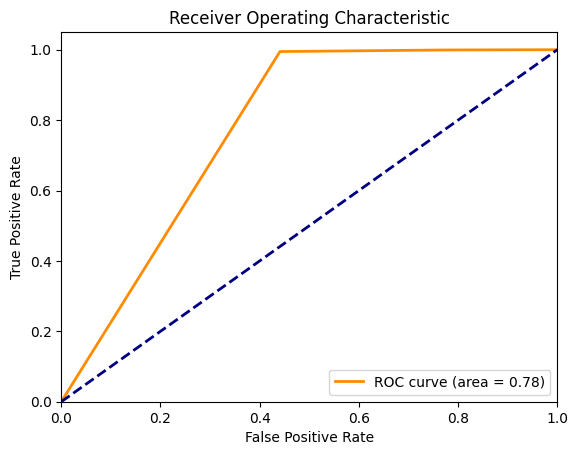

In [144]:
X = dfp_su_combined[[ 'tcp_flags_0x0011', 'tcp_flags_0x0010']]
y = dfp_su_combined['label'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Class distribution in training set:")
print(y_train.value_counts())
print("Class distribution in test set:")
print(y_test.value_counts())


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


if len(model.classes_) == 2:
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Class distribution in training set:
label
1    5373
0    4447
Name: count, dtype: int64
Class distribution in test set:
label
1    1346
0    1109
Name: count, dtype: int64
Cross-validated accuracy: 0.94 (+/- 0.12)
Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1109
           1       1.00      0.99      1.00      1346

    accuracy                           1.00      2455
   macro avg       1.00      1.00      1.00      2455
weighted avg       1.00      1.00      1.00      2455



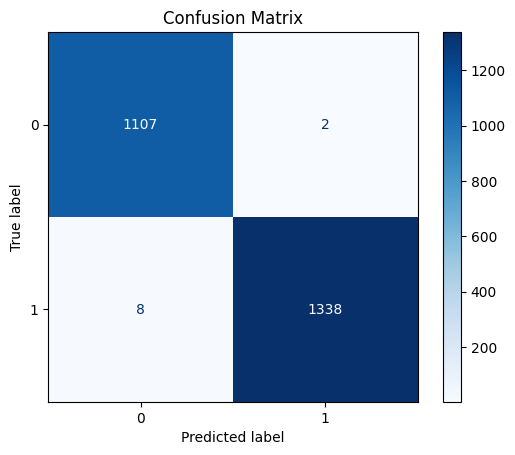

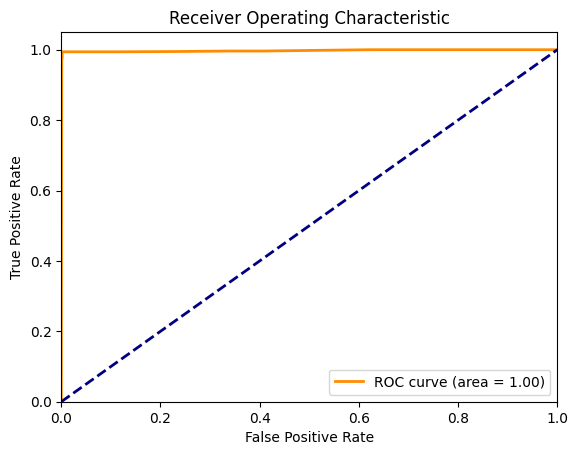

In [145]:
X = dfp_su_combined[[ 'tcp_seq', 'tcp_ack']] 
y = dfp_su_combined['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Class distribution in training set:")
print(y_train.value_counts())
print("Class distribution in test set:")
print(y_test.value_counts())

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

if len(model.classes_) == 2:
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

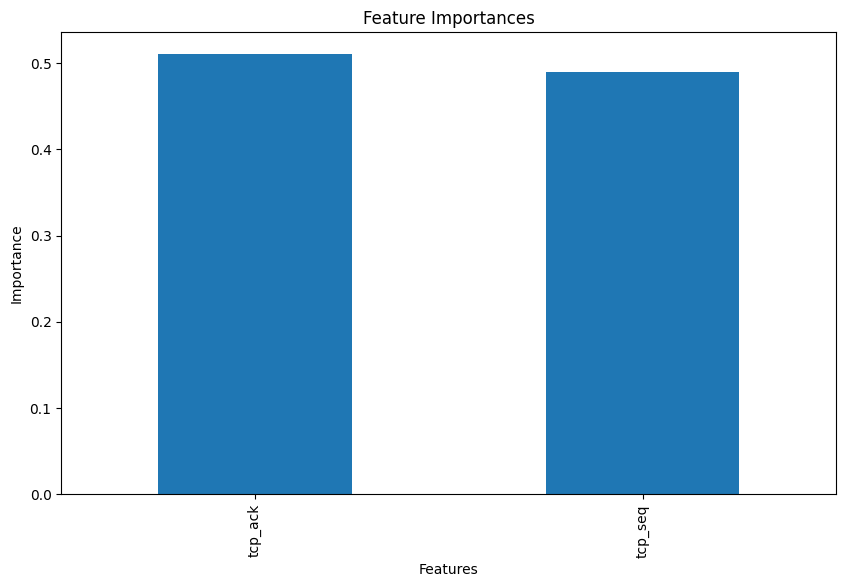

Selected Features using RFE: Index(['tcp_seq', 'tcp_ack'], dtype='object')


In [146]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=2)
selector = selector.fit(X_train, y_train)
selected_features = X.columns[selector.support_]
print("Selected Features using RFE:", selected_features)


In [147]:
print(dfp.dtypes)

timestamp      datetime64[ns]
length                 object
eth_src                object
eth_dst                object
raw_info               object
ip_src                 object
ip_dst                 object
ip_version             object
ip_ihl                 object
ip_tos                 object
ip_ttl                 object
ip_protocol            object
ip_flags               object
tcp_srcport            object
tcp_dstport            object
tcp_seq                object
tcp_ack                object
tcp_flags              object
dtype: object


In [148]:
one_hot_cols = ['eth_src', 'eth_dst', 'ip_src', 'ip_dst', 'ip_tos', 'ip_flags', 'tcp_flags']
dfp = pd.get_dummies(dfp, columns=one_hot_cols, drop_first=True) 
dfp['timestamp'] = pd.to_datetime(dfp['timestamp'])
dfp['timestamp_seconds'] = dfp['timestamp'].apply(lambda x: x.timestamp())
dfp.drop(columns=['timestamp'], inplace=True)
scaler = StandardScaler()
numeric_cols = ['length', 'ip_version', 'ip_ihl', 'ip_ttl', 'ip_protocol',
                'tcp_srcport', 'tcp_dstport', 'tcp_seq', 'tcp_ack', 'timestamp_seconds']
dfp[numeric_cols] = scaler.fit_transform(dfp[numeric_cols])

In [149]:
dfp_boolean_converted = dfp.select_dtypes(include=['bool']).astype(int)
dfp_numeric = dfp.select_dtypes(include=['float64', 'int64'])
dfp_combined = pd.concat([dfp_numeric, dfp_boolean_converted], axis=1)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(dfp_combined)
dfp['cluster'] = kmeans.labels_
dfp['label'] = dfp['cluster'].replace({dfp['cluster'].value_counts().idxmax(): 1, dfp['cluster'].value_counts().idxmin(): 0})
dfp = dfp.drop(columns=['cluster'])
dfp

,length,raw_info,ip_version,ip_ihl,ip_ttl,ip_protocol,tcp_srcport,tcp_dstport,tcp_seq,tcp_ack,...,ip_dst_192.168.1.103,ip_dst_192.168.1.104,ip_dst_192.168.1.105,ip_dst_192.168.1.106,tcp_flags_0x0010,tcp_flags_0x0011,tcp_flags_0x0012,tcp_flags_0x0018,timestamp_seconds,label
2,0.015468,Packet (Length: 62)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,0.295526,-0.859011,-0.812045,-0.812263,...,False,True,False,False,False,False,False,False,-1.728758,1
3,0.015468,Packet (Length: 62)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,-0.946518,0.435277,-0.812045,-0.812177,...,False,False,False,False,False,False,True,False,-1.728757,1
4,-1.151190,Packet (Length: 54)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,0.295526,-0.859011,-0.811959,-0.812177,...,False,True,False,False,True,False,False,False,-1.728756,1
5,0.598797,Packet (Length: 66)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,0.295526,-0.859011,-0.811959,-0.812177,...,False,True,False,False,False,False,False,True,-1.727250,1
6,0.307133,Packet (Length: 64)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,-0.946518,0.435277,-0.811959,-0.811141,...,False,False,False,False,False,False,False,True,-1.727240,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12291,0.598797,Packet (Length: 66)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,0.298826,-0.859011,2.620311,1.762070,...,False,True,False,False,False,False,False,True,1.720202,0
12292,0.161301,Packet (Length: 63)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,-0.946518,0.438716,1.762244,2.621188,...,False,False,False,False,False,False,False,True,1.720212,0
12293,0.598797,Packet (Length: 66)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,0.298826,-0.859011,2.621348,1.762847,...,False,True,False,False,False,False,False,True,1.721230,0
12294,0.161301,Packet (Length: 63)\nLayer ETH\n:\tDestination...,0.0,0.0,0.0,0.0,-0.946518,0.438716,1.763021,2.622224,...,False,False,False,False,False,False,False,True,1.721239,0


In [150]:
label_percentages = dfp['label'].value_counts(normalize=True) * 100
print(label_percentages)
for label, percentage in label_percentages.items():
    print(f"Label {label}: {percentage:.2f}%")


label
1    62.892057
0    37.107943
Name: proportion, dtype: float64
Label 1: 62.89%
Label 0: 37.11%


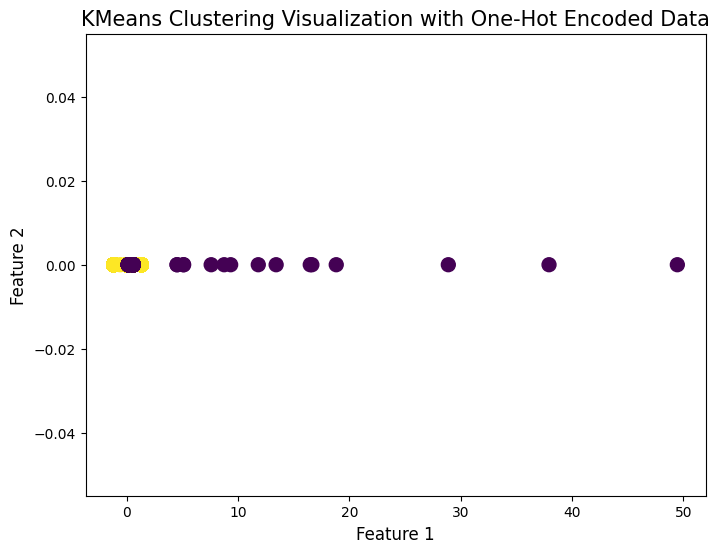

In [151]:
plt.figure(figsize=(8, 6))
plt.scatter(dfp_combined.iloc[:, 0], dfp_combined.iloc[:, 1], c=dfp['label'], cmap='viridis', s=100)
plt.title("KMeans Clustering Visualization with One-Hot Encoded Data", fontsize=15)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.show()


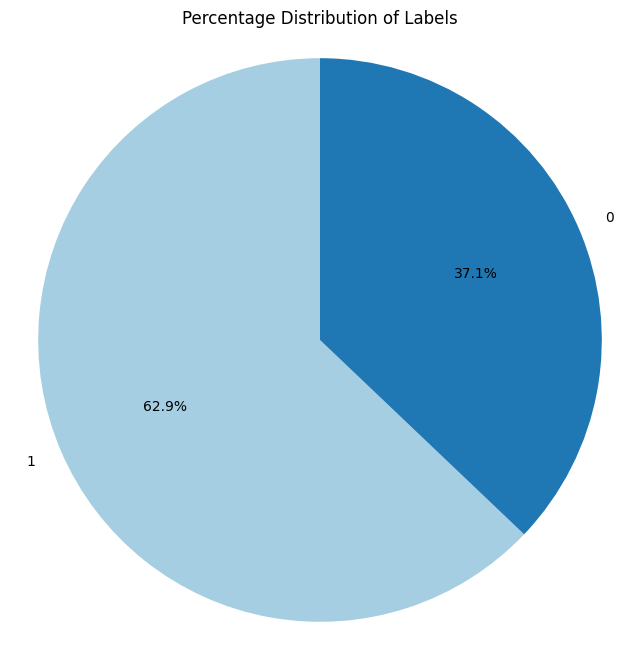

In [152]:
label_counts = dfp['label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Percentage Distribution of Labels')
plt.axis('equal')
plt.show()

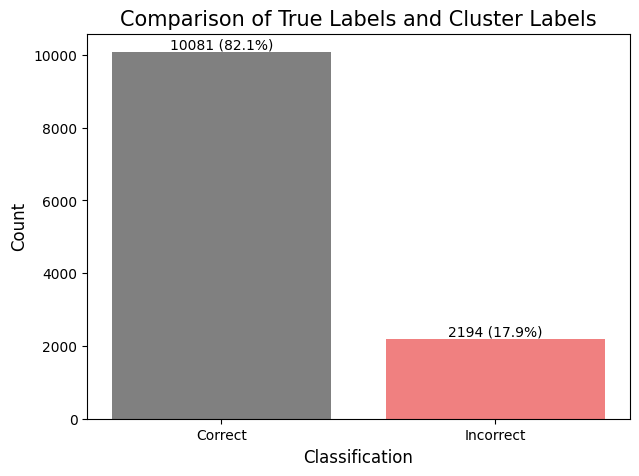

In [153]:
merged_df['cluster_label'] = dfp['label'].astype(int)
merged_df['correct'] = merged_df['label'] == merged_df['cluster_label']
comparison_counts = merged_df['correct'].value_counts()
total_count = len(merged_df)
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(comparison_counts.index.map({True: 'Incorrect', False: 'Correct'}),
              comparison_counts.values,
              color=['gray', 'lightcoral'])
ax.set_xlabel('Classification', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Comparison of True Labels and Cluster Labels', fontsize=15)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height} ({percentage:.1f}%)',
            ha='center', va='bottom')
plt.show()


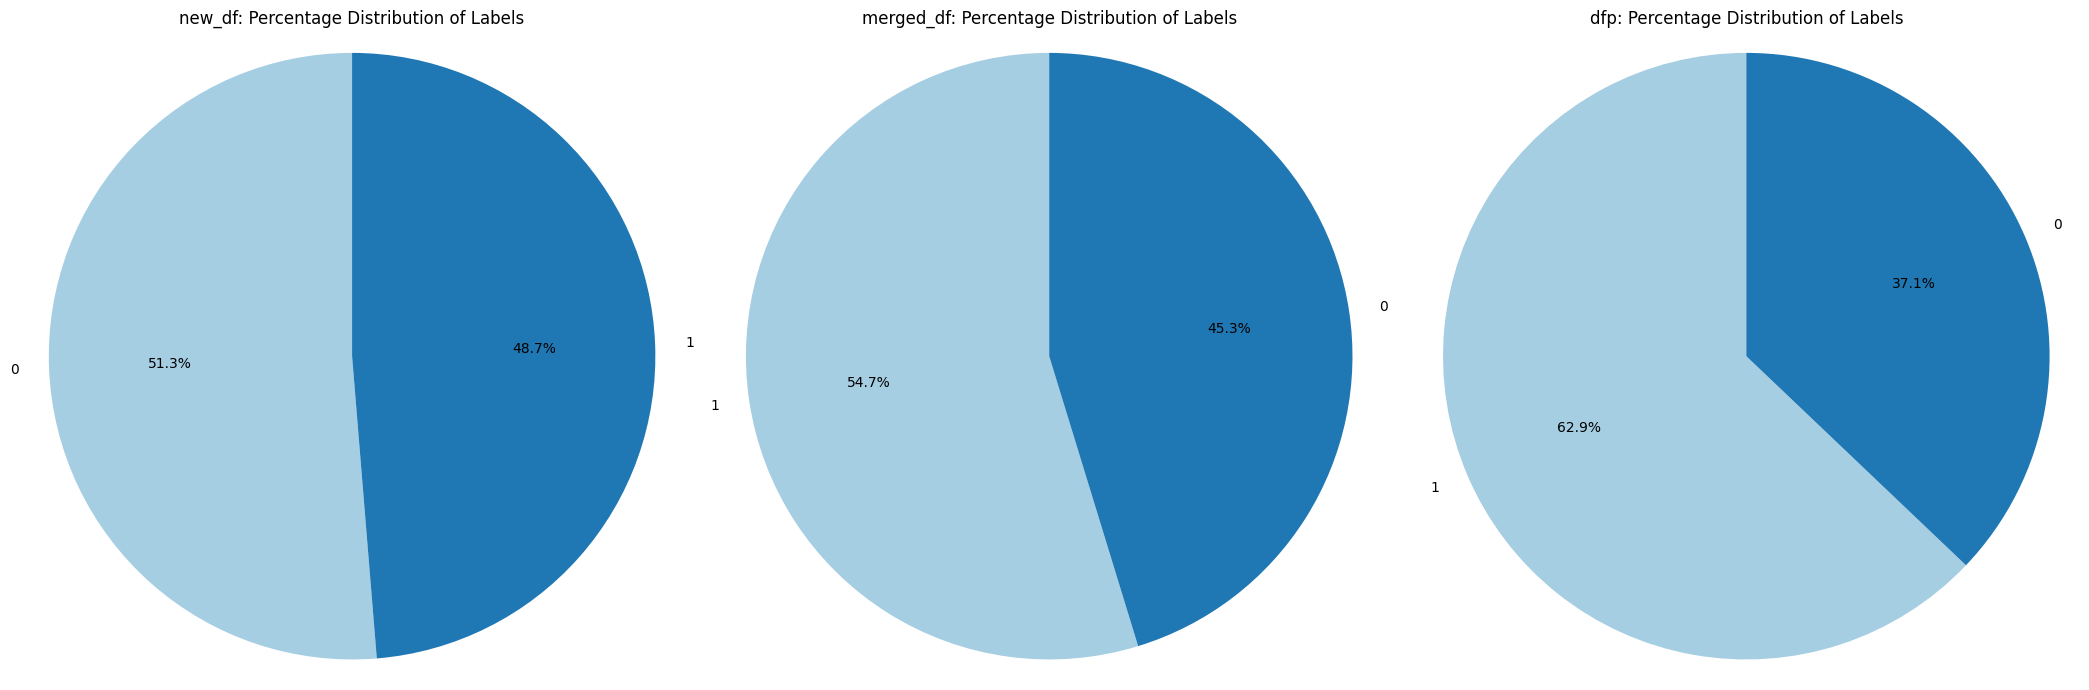

In [154]:


label_counts1 = new_df['label'].value_counts(normalize=True) * 100
label_counts2 = merged_df['label'].value_counts(normalize=True) * 100
label_counts3 = dfp['label'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

axes[0].pie(label_counts1, labels=label_counts1.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0].set_title('new_df: Percentage Distribution of Labels')
axes[0].axis('equal')

axes[1].pie(label_counts2, labels=label_counts2.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[1].set_title('merged_df: Percentage Distribution of Labels')
axes[1].axis('equal')

axes[2].pie(label_counts3, labels=label_counts3.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[2].set_title('dfp: Percentage Distribution of Labels')
axes[2].axis('equal')

plt.tight_layout()
plt.show()


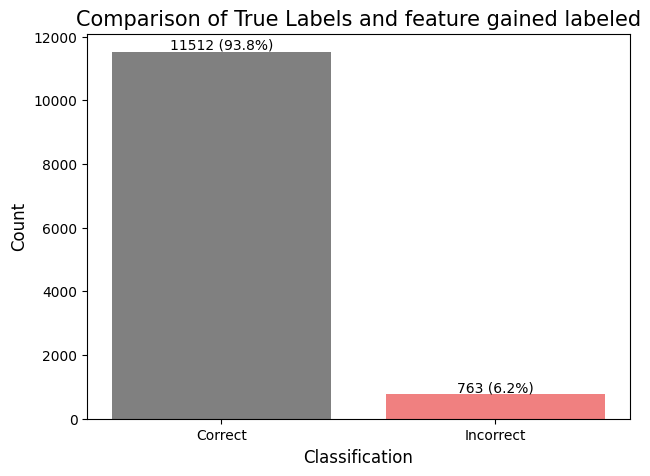

In [155]:
merged_df['simple_label'] = new_df['label'].astype(int)
merged_df['correct'] = merged_df['label'] == merged_df['simple_label']
comparison_counts_merged = merged_df['correct'].value_counts()
total_count_merged = len(merged_df)

fig, ax = plt.subplots(figsize=(7, 5))
bars_merged = ax.bar(comparison_counts_merged.index.map({True: 'Correct', False: 'Incorrect'}),
                     comparison_counts_merged.values,
                     color=['gray', 'lightcoral'])
ax.set_xlabel('Classification', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Comparison of True Labels and feature gained labeled', fontsize=15)
for bar in bars_merged:
    height = bar.get_height()
    percentage = (height / total_count_merged) * 100
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height} ({percentage:.1f}%)',
            ha='center', va='bottom')
plt.show()


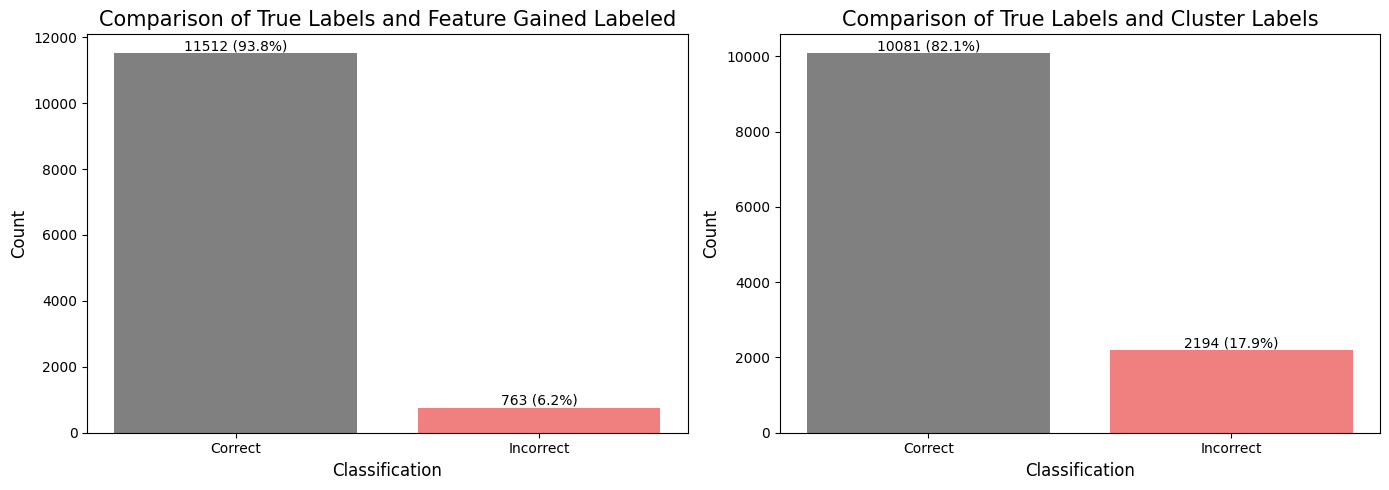

In [156]:
merged_df['simple_label'] = new_df['label'].astype(int)
merged_df['correct'] = merged_df['label'] == merged_df['simple_label']
comparison_counts_merged = merged_df['correct'].value_counts()
total_count_merged = len(merged_df)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

bars_merged = ax[0].bar(comparison_counts_merged.index.map({True: 'Correct', False: 'Incorrect'}),
                        comparison_counts_merged.values,
                        color=['gray', 'lightcoral'])
ax[0].set_xlabel('Classification', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Comparison of True Labels and Feature Gained Labeled', fontsize=15)
for bar in bars_merged:
    height = bar.get_height()
    percentage = (height / total_count_merged) * 100
    ax[0].text(bar.get_x() + bar.get_width() / 2, height,
               f'{height} ({percentage:.1f}%)',
               ha='center', va='bottom')

merged_df['cluster_label'] = dfp['label'].astype(int)
merged_df['correct'] = merged_df['label'] == merged_df['cluster_label']
comparison_counts = merged_df['correct'].value_counts()
total_count = len(merged_df)

bars = ax[1].bar(comparison_counts.index.map({True: 'Incorrect', False: 'Correct'}),
                  comparison_counts.values,
                  color=['gray', 'lightcoral'])
ax[1].set_xlabel('Classification', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
ax[1].set_title('Comparison of True Labels and Cluster Labels', fontsize=15)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    ax[1].text(bar.get_x() + bar.get_width() / 2, height,
               f'{height} ({percentage:.1f}%)',
               ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [157]:
print("Updated Code for Michael!")

Updated Code for Michael!
